# Reciprocity and sensitivity kernels for sea level fingerprints

This notebook illustrates the reciprocity relations discussed in the paper by Al-Attar *et al.* (2023)
of the same name which has been submitted to GJI. In particular, this notebook includes code used to generate 
all the figures included within that paper. You can also run the python script MakeFigures.py which makes and saves the figures in a chosen directory.



In [1]:
%load_ext autoreload
%autoreload 2

# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pyshtools as pysh
import SLmod as SL
import RFmod as RF
from numpy import pi as pi



# get values for some physical parameters
b = SL.b
g = SL.g
G = SL.G
rhoi = SL.rhoi
rhow = SL.rhow
rhos = SL.rhos

In [15]:
#set plotting parameters
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [16, 8]

Now we read in the present day distribution of sea level and ice. This is taken from the ice6g model of:

https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014JB011176

The values of the fields are interpolated onto a Gauss Legendre grid at the chosen expansion order. Note that for the calculations in this notebook L = 256 or higher is a sensible value. The maximum possible is L = 4096, this being set by the Love numbers that have been pre-calculated and are read in below. 

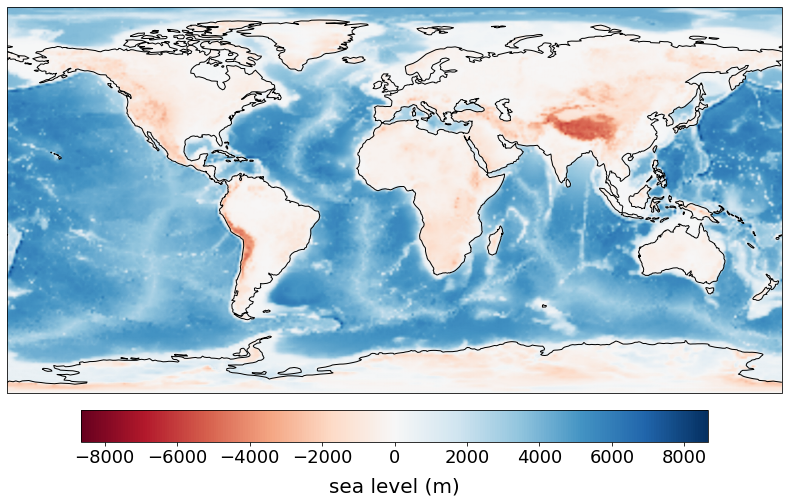

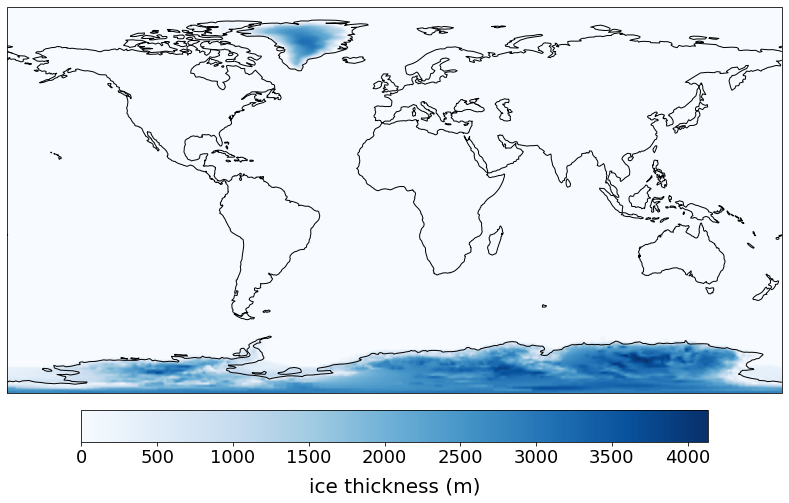

fraction of surface which is ocean =  0.711621825201443


In [53]:
# set the truncation degree
L=512

# read in the present day sea level and ice thickness
sl0,ice0 = SL.get_sl_ice_data(L)

# plot these fields
SL.plot(sl0,label = 'sea level (m)')
SL.plot(ice0,label = 'ice thickness (m)',clim_pos = True)

# compute the ocean function
C = SL.ocean_function(sl0,ice0)

# work out the ocean area and check the value
A = SL.surface_integral(C)
A_earth = 4*pi*b**2
print('fraction of surface which is ocean = ',A/A_earth)


## Solving the sea level equation to make a synthetic data set


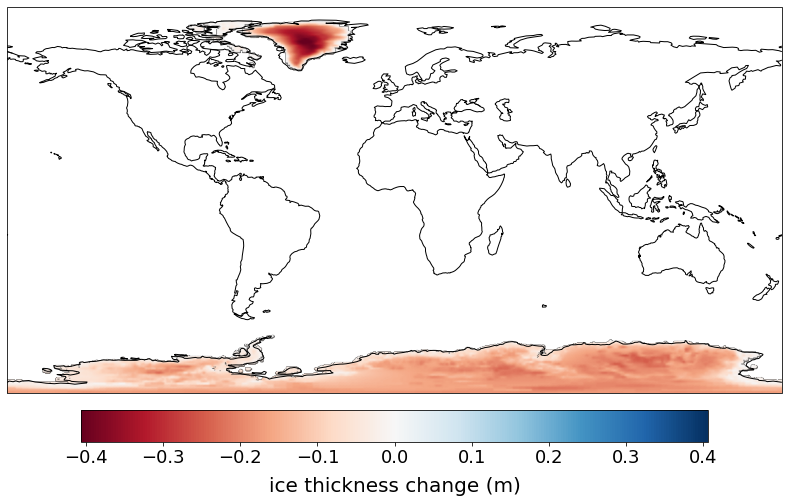

iteration =  1 relative change =  0.04652523137183932
iteration =  2 relative change =  0.0059615290606239765
iteration =  3 relative change =  0.0010592599330010249
iteration =  4 relative change =  0.00021272807600618382
iteration =  5 relative change =  4.6599585088720595e-05
iteration =  6 relative change =  1.097180256793389e-05
iteration =  7 relative change =  2.7554263029362613e-06
iteration =  8 relative change =  7.335485794037802e-07
iteration =  9 relative change =  2.0543811262835813e-07
iteration =  10 relative change =  5.996303177791678e-08
iteration =  11 relative change =  1.806290472920413e-08
iteration =  12 relative change =  5.567421367712806e-09


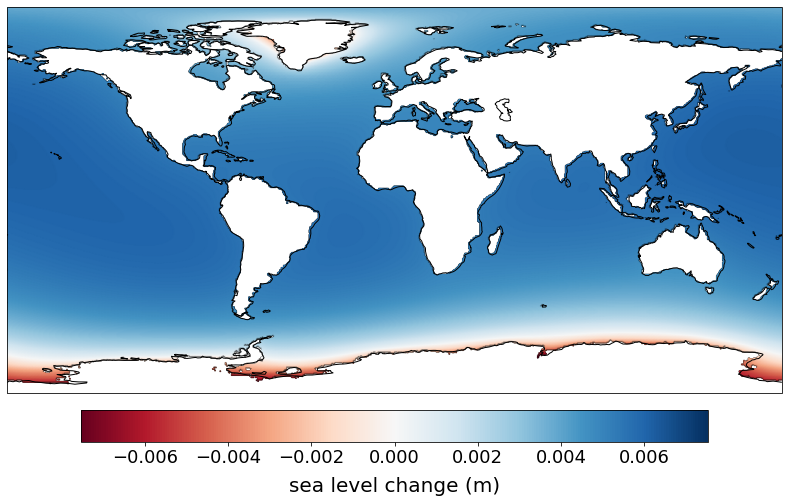

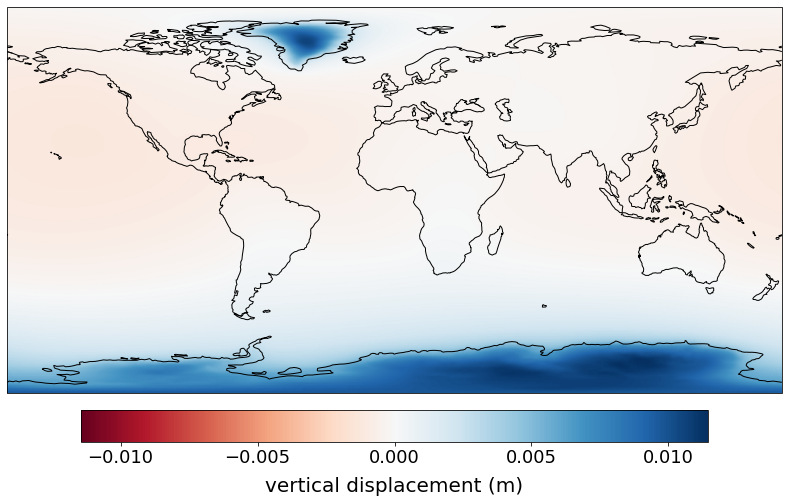

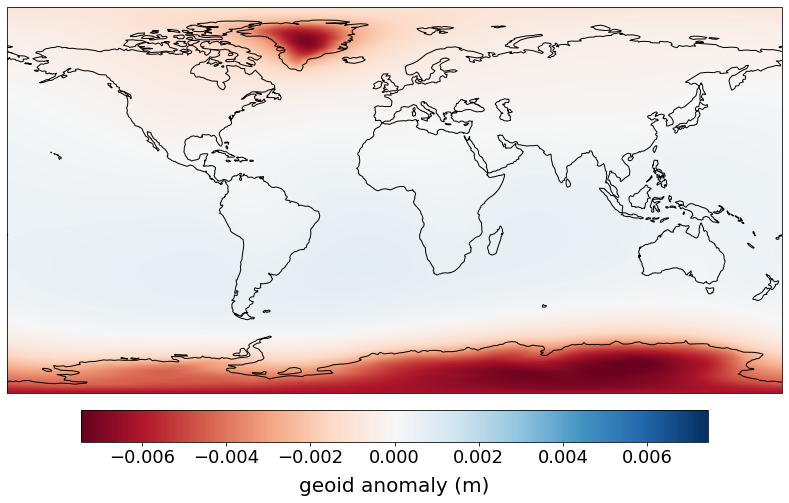

In [54]:
# set to true to use a random ice change model
use_random = False

if(use_random):
    Q = RF.sobolev_covariance(L,s = 2,mu = 0.2)
    zeta_north = -rhoi*SL.greenland_mask(sl0,ice0,val = 0.)*RF.random_field(Q)
    zeta_south = -rhoi*SL.antarctica_mask(sl0,ice0,val = 0.)*RF.random_field(Q)
else:
    zeta_north = -rhoi*SL.zero_southern_hemisphere(ice0)
    zeta_south = -rhoi*SL.zero_northern_hemisphere(ice0)
        
    
# normalise by GMSL contributions
GMSL_north = SL.bathtub(C,zeta_north)
GMSL_south = SL.bathtub(C,zeta_south)
zeta_north /= GMSL_north
zeta_south /= GMSL_south

# set the rate of GMSL change in mm
GMSL = 0.005

# set the northern and southern fractions
f_north = 0.2
f_south = 1.-f_north

# set the combined ice load
zeta = GMSL*(f_north*zeta_north + f_south*zeta_south)

# plot the result with suitable mask
ice_mask = SL.ice_mask(sl0,ice0)
SL.plot(ice_mask*zeta/SL.rhoi,label = r'ice thickness change (m)')

# solve the fingerprint problem
sl,u,phi,om,psi = SL.fingerprint(C,zeta)
ocean_mask = SL.ocean_mask(sl0,ice0)

# plot the result globally
SL.plot(ocean_mask*sl,label = r'sea level change (m)')
SL.plot(u,label = r'vertical displacement (m)')
SL.plot(-1*phi/g,label = r'geoid anomaly (m)')



## Sensitivity kernel for sea level at a given location


iteration =  1 relative change =  0.0058616132565838365
iteration =  2 relative change =  0.00012501562286098688
iteration =  3 relative change =  1.3986201063342604e-05
iteration =  4 relative change =  2.722213081994967e-06
iteration =  5 relative change =  5.923168063092005e-07
iteration =  6 relative change =  1.3890784970111924e-07
iteration =  7 relative change =  3.49187676018559e-08
iteration =  8 relative change =  9.360166504875663e-09


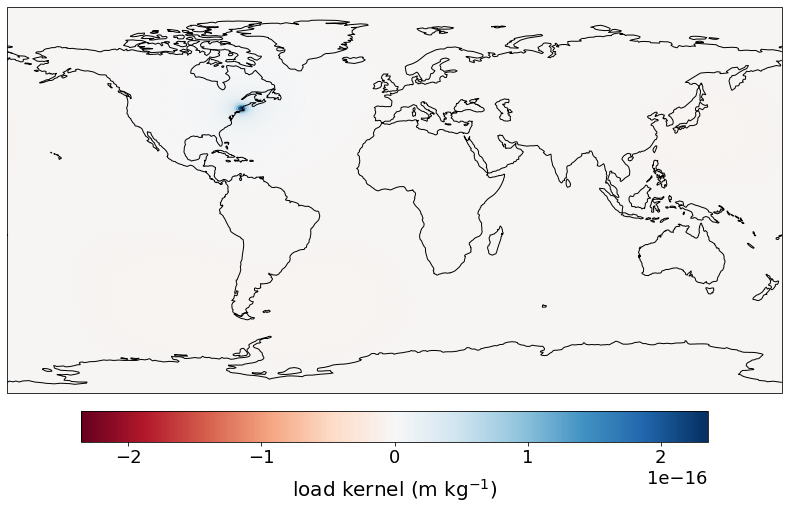

direct sea level value =  0.0046400193800976005
left hand side         =  0.004640019380097613
right hand side        =  0.00464002189849137
relative difference    =  5.427550083572035e-07


In [55]:
# set the observation point to Boston
lat =  42.3601
lon = -71.0589


# compute the adjoint load
zeta_d,_,_,_ = SL.sea_level_load(L,lat,lon,angle = 0.)

# solve the sea level equation for SL^{\dagger} and plot
sl_d,_,_,_,_ = SL.fingerprint(C,zeta_d)
SL.plot(sl_d,label = r'load kernel (m kg$^{-1}$)',clim_scale = 0.1)


# set the value of sea level directly from the field 
sl_direct = SL.point_evaluation(sl,lat,lon)

# evaluate the sea level by integration against the delta load
lhs = SL.surface_integral(zeta_d*sl)

# now get the value by integrating the sensitivity kernel against the direct load
rhs = SL.surface_integral(sl_d*zeta)

# print the values out along with the relative difference
print('direct sea level value = ',sl_direct)
print('left hand side         = ',lhs)
print('right hand side        = ',rhs)
print('relative difference    = ', np.abs((lhs-rhs)/lhs))


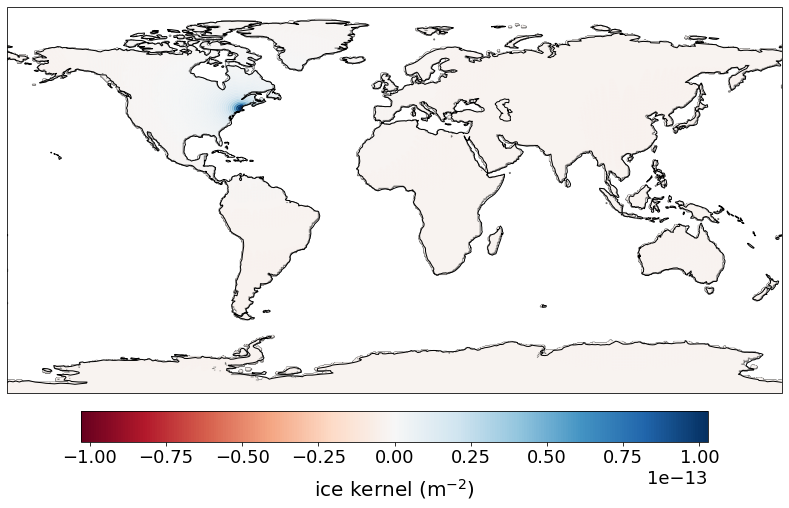

In [56]:
# define and plot the sensitivity kernel with respect to ice thickness
K = SL.rhoi*(1-C)*sl_d
land_mask = SL.land_mask(sl0,ice0)
SL.plot(land_mask*K,label = r'ice kernel (m$^{-2}$)',clim_scale = 0.1)

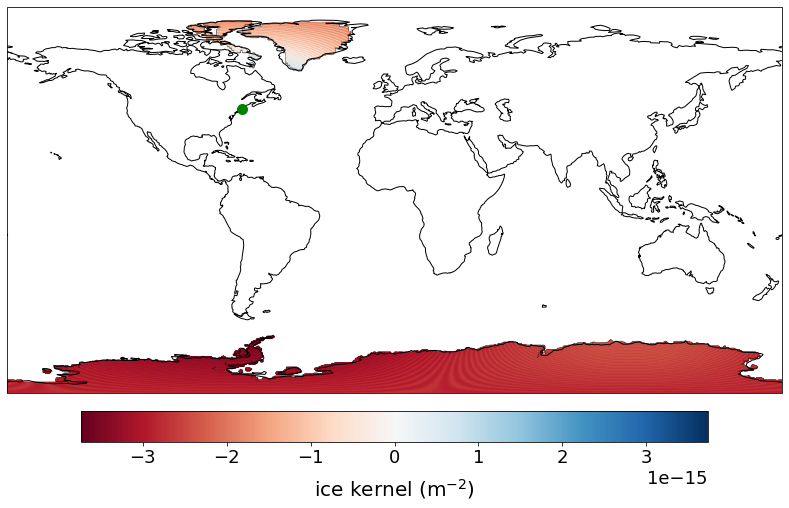

In [57]:
# re-define the kernel such that it is non-zero only where there is grounded ice
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-2}$)',marker = [lat,lon])

iteration =  1 relative change =  0.01481231281950375
iteration =  2 relative change =  0.0005662749280904383
iteration =  3 relative change =  6.854869443207076e-05
iteration =  4 relative change =  1.3358884274005619e-05
iteration =  5 relative change =  2.9082049754157487e-06
iteration =  6 relative change =  6.82308570359895e-07
iteration =  7 relative change =  1.715851667745797e-07
iteration =  8 relative change =  4.6009712185437966e-08
iteration =  9 relative change =  1.3145196342452857e-08
iteration =  10 relative change =  4.017317936041938e-09


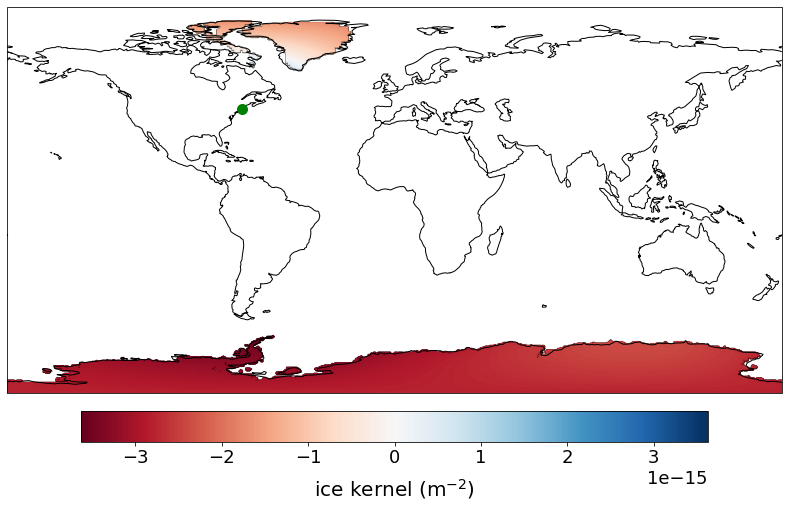

In [58]:
# compute the adjoint load for a SMOOTHED point load
zeta_d,_,_,_ = SL.sea_level_load(L,lat,lon,angle = 1.)

# solve the sea level equation for SL^{\dagger} and plot
sl_d,_,_,_,_ = SL.fingerprint(C,zeta_d)

# set and plot the kernel projected onto regions of grounded ice
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-2}$)',marker = [lat,lon])


## Sensitivity kernel for vertical displacement measurement



iteration =  1 relative change =  0.0017822127490222596
iteration =  2 relative change =  7.78880000219191e-05
iteration =  3 relative change =  8.137559856818894e-06
iteration =  4 relative change =  1.1632216373117915e-06
iteration =  5 relative change =  2.09524271928313e-07
iteration =  6 relative change =  5.108381629111035e-08
iteration =  7 relative change =  1.3372610336793725e-08
iteration =  8 relative change =  3.7246115544742763e-09

direct displacement value =  0.0009003159011080396
left hand side            =  0.0009003164669098634
right hand side           =  0.0009003159011080549
relative difference       =  6.284476951205617e-07

iteration =  1 relative change =  0.01048803933295354
iteration =  2 relative change =  0.0004309538915333822
iteration =  3 relative change =  4.343918406307858e-05
iteration =  4 relative change =  6.194530152435297e-06
iteration =  5 relative change =  1.0663254315935832e-06
iteration =  6 relative change =  2.5923294211005034e-07
iteration

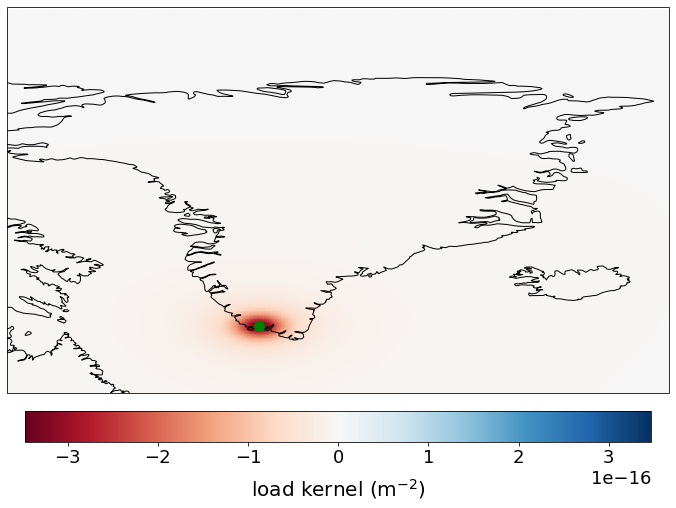

In [59]:
# set the observation point at SENU GPS station in Greenland
#lat = 40.6401
#lon = 22.9444

lat = 61.0696
lon = -47.1413

zeta_d,zeta_u_d,zeta_phi_d,kk_d = SL.displacement_load(L,lat,lon,angle = 0)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# get the displacement directly
u_lm = u.expand();
u_direct = pysh.expand.MakeGridPoint(u_lm.coeffs,lat,lon+180)

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct displacement value = ',u_direct)
print('left hand side            = ', lhs)
print('right hand side           = ',rhs)
print('relative difference       = ', np.abs((lhs-rhs)/lhs))
print('')


# compute and plot the sensitivity kernel wrt ice thickness, but smoothing the point load
zeta_d,zeta_u_d,zeta_phi_d,kk_d = SL.displacement_load(L,lat,lon,angle = 1)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(sl_d,label = r'load kernel (m$^{-2}$)',xlim = [-70,-10],ylim = [55,90],marker = [lat,lon])

iteration =  1 relative change =  0.0019340507277033393
iteration =  2 relative change =  9.576346266050545e-05
iteration =  3 relative change =  1.1137422908642468e-05
iteration =  4 relative change =  1.7993031711566105e-06
iteration =  5 relative change =  3.4461661579052645e-07
iteration =  6 relative change =  7.06927987679293e-08
iteration =  7 relative change =  1.517566953432355e-08
iteration =  8 relative change =  3.449257047362641e-09

direct displacement value =  0.0019109901479832062
left hand side            =  0.0019109902101631458
right hand side           =  0.0019109901479832147
relative difference       =  3.253806890019171e-08

iteration =  1 relative change =  0.011196347605696684
iteration =  2 relative change =  0.0005443409139189624
iteration =  3 relative change =  6.121409688096165e-05
iteration =  4 relative change =  9.806252269623753e-06
iteration =  5 relative change =  1.871278673459703e-06
iteration =  6 relative change =  3.838295698254093e-07
iteration

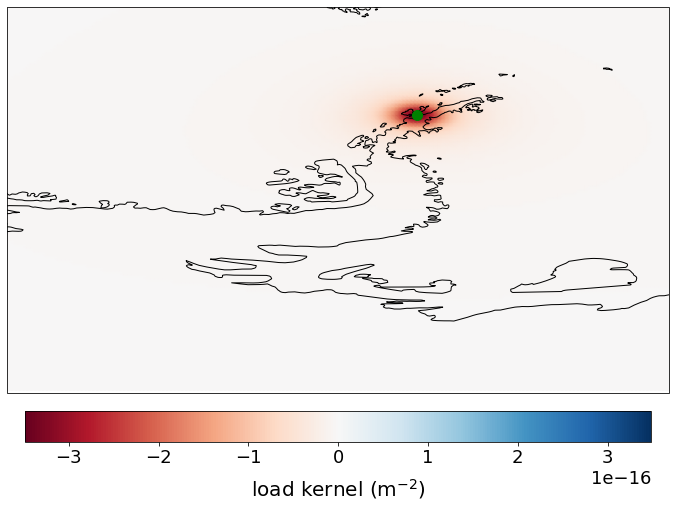

In [60]:
# set the observation point BLAS GPS station in Greeland
#lat = -37.8136
#lon = -22.9747

lat = -64.80495000
lon = 	-62.81690000

zeta_d,zeta_u_d,zeta_phi_d,kk_d = SL.displacement_load(L,lat,lon,angle = 0)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# get the displacement directly
u_lm = u.expand();
u_direct = pysh.expand.MakeGridPoint(u_lm.coeffs,lat,lon+180)

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct displacement value = ',u_direct)
print('left hand side            = ', lhs)
print('right hand side           = ',rhs)
print('relative difference       = ', np.abs((lhs-rhs)/lhs))
print('')


# compute and plot the sensitivity kernel wrt ice thickness, but smoothing the point load
zeta_d,zeta_u_d,zeta_phi_d,kk_d = SL.displacement_load(L,lat,lon,angle = 1)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(sl_d,label = r'load kernel (m$^{-2}$)',marker = [lat,lon],xlim = [-100,-40],ylim = [-90,-55])

## Sensitivity kernel for gravitational potential coefficient measurement


iteration =  1 relative change =  0.12119451762167566
iteration =  2 relative change =  0.014910712306349607
iteration =  3 relative change =  0.001972350278071532
iteration =  4 relative change =  0.0003227018328667932
iteration =  5 relative change =  6.043114180890681e-05
iteration =  6 relative change =  1.2842134462341996e-05
iteration =  7 relative change =  3.3163426666073217e-06
iteration =  8 relative change =  9.095618510949225e-07
iteration =  9 relative change =  2.5277188781016215e-07
iteration =  10 relative change =  7.196457344533109e-08
iteration =  11 relative change =  2.1047018956299015e-08
iteration =  12 relative change =  6.311358476693929e-09

direct potential value    =  -0.0014273045524179906
left hand side            =  -0.0014273044962509395
right hand side           =  -0.0014273045524179912
relative difference       =  3.9351835465340516e-08



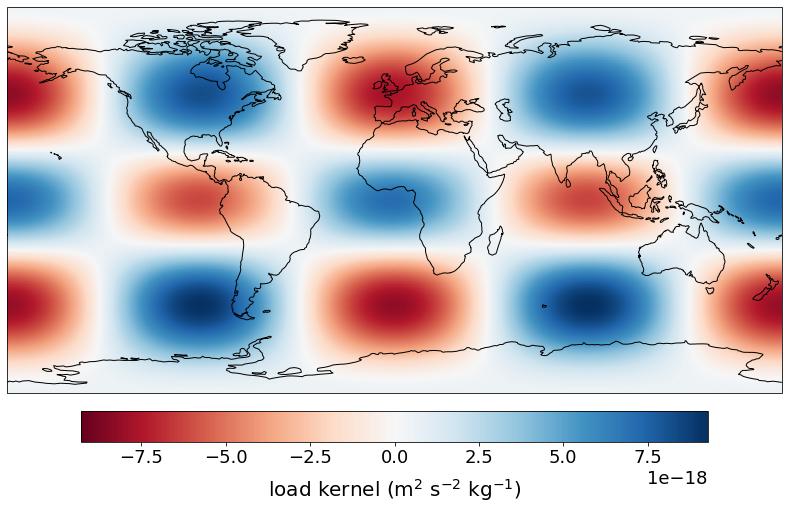

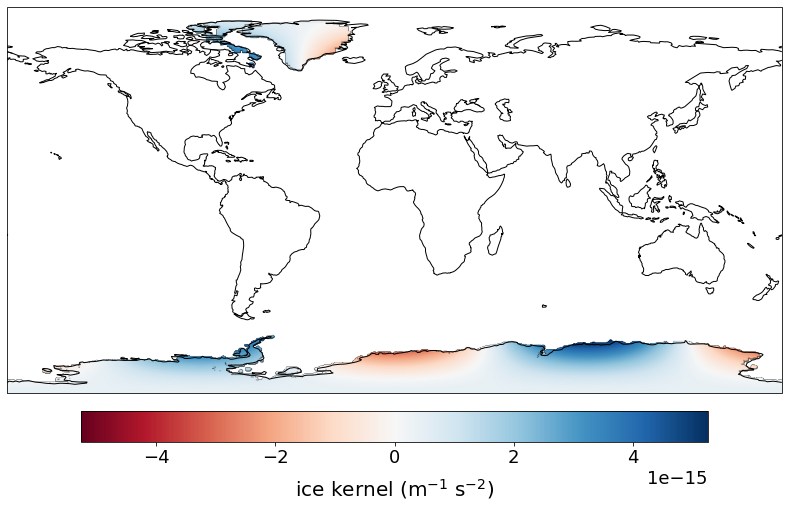

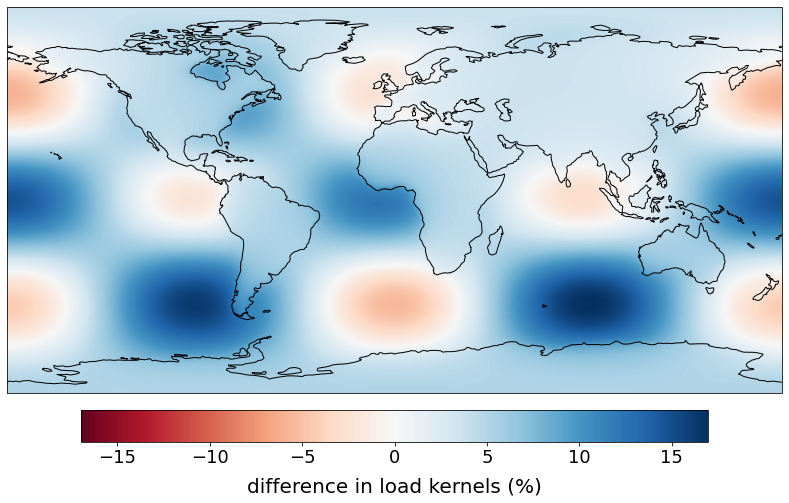

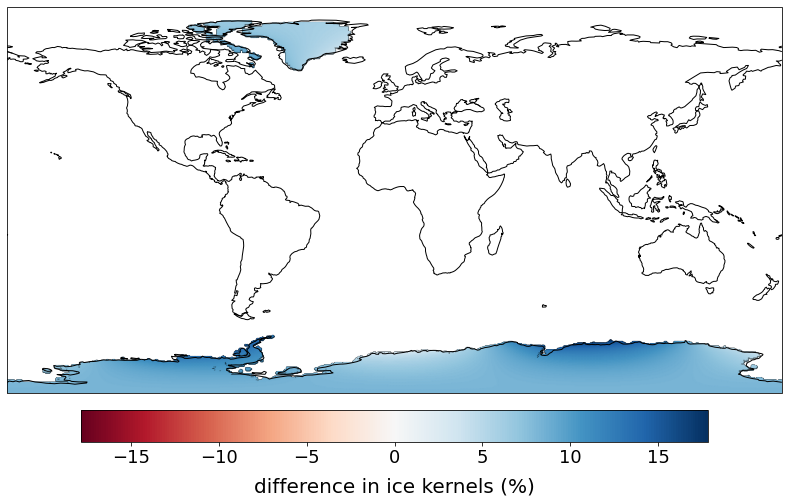

In [61]:
# set the adjoint loads
l = 4
m = 2
zeta_d, zeta_u_d, zeta_phi_d, kk_d = SL.potential_coefficient_load(L,l,m,remove_psi = True)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# get the potential coefficient directly
phi_lm = phi.expand(normalization='ortho')
if(m >= 0):
    phi_direct = phi_lm.coeffs[0,l,m]
else:
    phi_direct = phi_lm.coeffs[1,l,-m]

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct potential value    = ',phi_direct)
print('left hand side            = ',lhs)
print('right hand side           = ',rhs)
print('relative difference       = ',np.abs((lhs-rhs)/lhs))
print('')


# plot the sensitivity kernel wrt zeta
SL.plot(sl_d,label = r'load kernel (m$^{2}$ s$^{-2}$ kg$^{-1}$)')


# plot the sensitivity kernel wrt ice
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-1}$ s$^{-2}$)')

# get the love numbers
_,k,_,_ = SL.love_numbers(L)

# compute the kernel ignoring water loading
K_d_lm = pysh.SHCoeffs.from_zeros(lmax=L,normalization = 'ortho')
if(m > 0):
    K_d_lm.coeffs[0,l,m] = k[l]/SL.b**2
else:
    K_d_lm.coeffs[1,l,-m] = k[l]/SL.b**2   
K_d = K_d_lm.expand(grid = 'GLQ')


# plot the sensitivity kernel wrt zeta minus direct kernel
norm = np.max(np.abs(sl_d.data))
SL.plot(100*(sl_d-K_d)/norm,label = r'difference in load kernels (%)')


# plot the sensitivity kernel wrt ice
K1 = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
K2 = SL.rhoi*(1-C)*K_d*SL.ice_mask(sl0,ice0,val = 0.)
norm = np.max(np.abs(K1.data))
SL.plot(100*ice_mask*(K1-K2)/norm,label = r'difference in ice kernels (%)')


iteration =  1 relative change =  0.042633972993468806
iteration =  2 relative change =  0.002144399129994049
iteration =  3 relative change =  0.00014838928141033424
iteration =  4 relative change =  1.6422028943442078e-05
iteration =  5 relative change =  2.732068382276921e-06
iteration =  6 relative change =  5.504558337852335e-07
iteration =  7 relative change =  1.2348270080072075e-07
iteration =  8 relative change =  2.9528938687040933e-08
iteration =  9 relative change =  7.45560572237378e-09

direct potential value    =  0.0005180870425242541
left hand side            =  0.0005180870343899478
right hand side           =  0.0005180870425242545
relative difference       =  1.570065677159983e-08



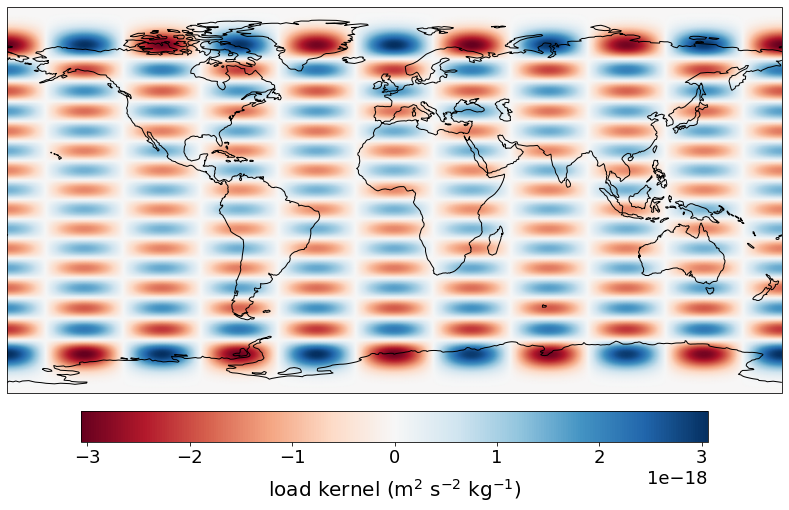

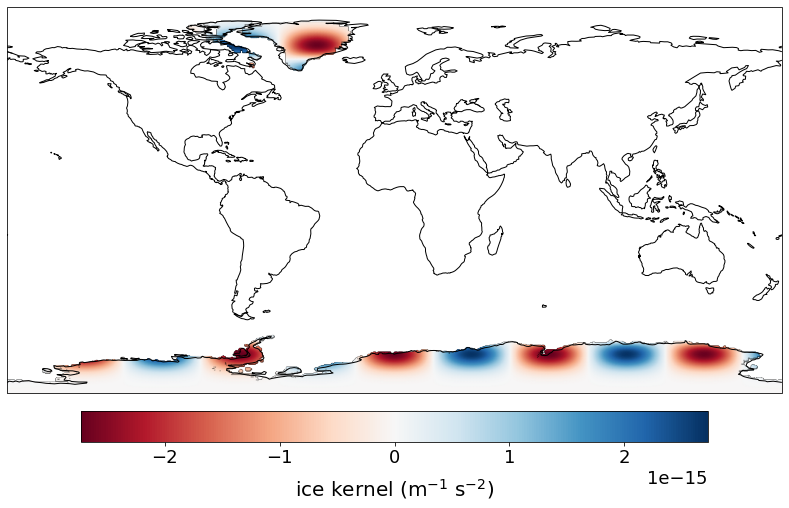

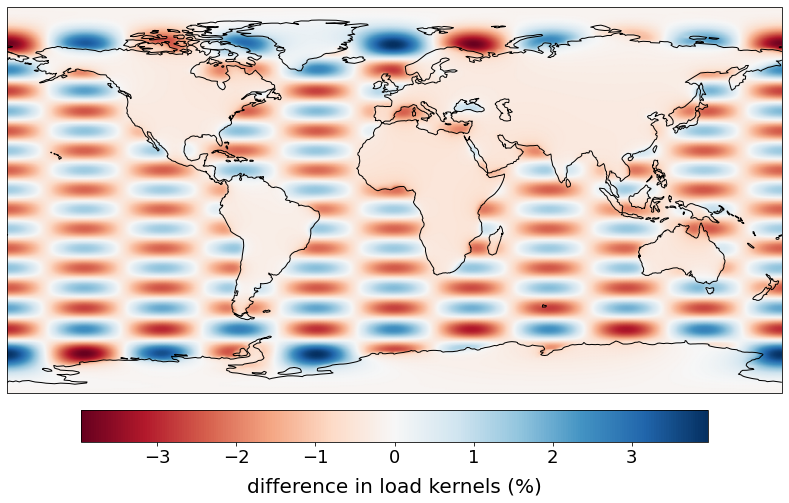

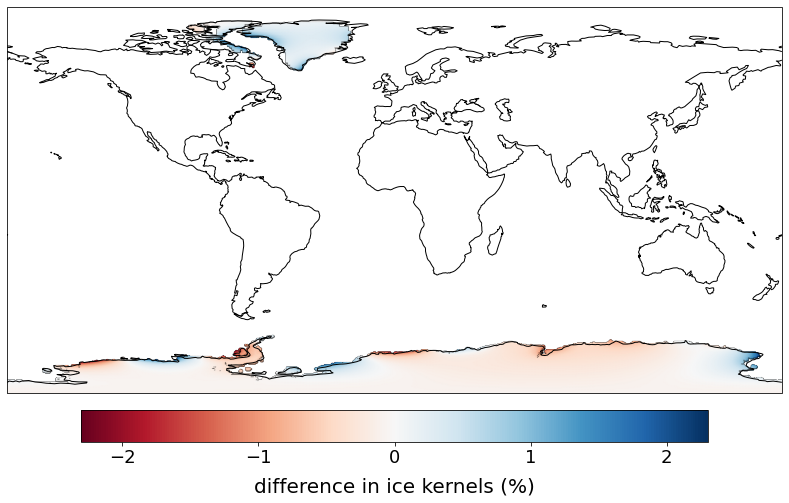

In [62]:
# set the adjoint loads for a higher degree
l = 20
m = 5
zeta_d, zeta_u_d, zeta_phi_d, kk_d = SL.potential_coefficient_load(L,l,m,remove_psi = True)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# get the potential coefficient directly
phi_lm = phi.expand(normalization='ortho')
if(m >= 0):
    phi_direct = phi_lm.coeffs[0,l,m]
else:
    phi_direct = phi_lm.coeffs[1,l,-m]

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct potential value    = ',phi_direct)
print('left hand side            = ',lhs)
print('right hand side           = ',rhs)
print('relative difference       = ',np.abs((lhs-rhs)/lhs))
print('')


# plot the sensitivity kernel wrt zeta
SL.plot(sl_d,label = r'load kernel (m$^{2}$ s$^{-2}$ kg$^{-1}$)')


# plot the sensitivity kernel wrt ice
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-1}$ s$^{-2}$)')

# get the love numbers
_,k,_,_ = SL.love_numbers(L)

# compute the kernel ignoring water loading
K_d_lm = pysh.SHCoeffs.from_zeros(lmax=L,normalization = 'ortho')
if(m > 0):
    K_d_lm.coeffs[0,l,m] = k[l]/SL.b**2
else:
    K_d_lm.coeffs[1,l,-m] = k[l]/SL.b**2   
K_d = K_d_lm.expand(grid = 'GLQ')


# plot the sensitivity kernel wrt zeta minus direct kernel
norm = np.max(np.abs(sl_d.data))
SL.plot(100*(sl_d-K_d)/norm,label = r'difference in load kernels (%)')


# plot the sensitivity kernel wrt ice
K1 = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
K2 = SL.rhoi*(1-C)*K_d*SL.ice_mask(sl0,ice0,val = 0.)
norm = np.max(np.abs(K1.data))
SL.plot(100*ice_mask*(K1-K2)/norm,label = r'difference in ice kernels (%)')


## Sensitivity kernels for Grace load averages

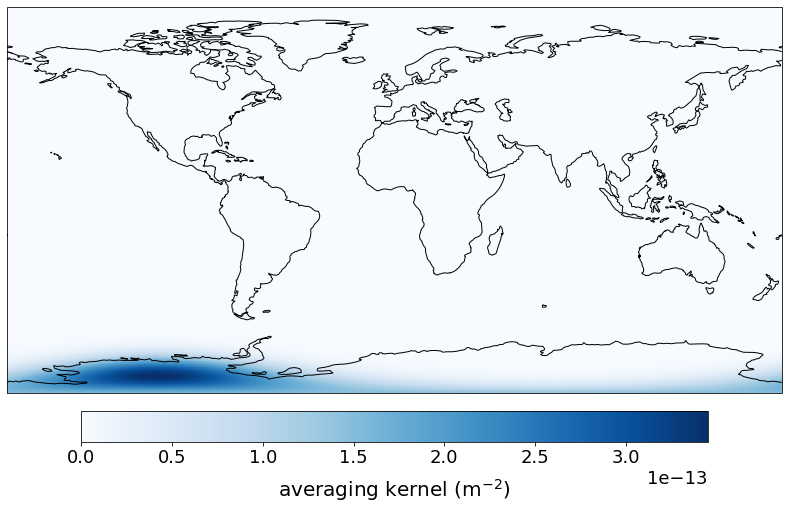

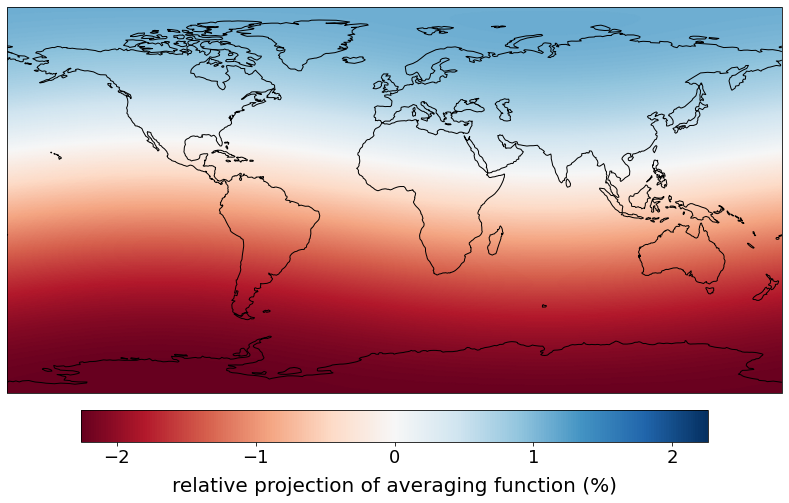

iteration =  1 relative change =  0.018770864053490478
iteration =  2 relative change =  0.0008541371347517465
iteration =  3 relative change =  8.888231148053567e-05
iteration =  4 relative change =  1.823116436581372e-05
iteration =  5 relative change =  3.990174315302519e-06
iteration =  6 relative change =  9.374256831303953e-07
iteration =  7 relative change =  2.366246172812444e-07
iteration =  8 relative change =  6.376487256242285e-08
iteration =  9 relative change =  1.8133642810322672e-08
iteration =  10 relative change =  5.3725248079076765e-09

left hand side            =  -63.66787001819527
right hand side           =  -63.66787649251515
relative difference       =  1.0168896608340495e-07



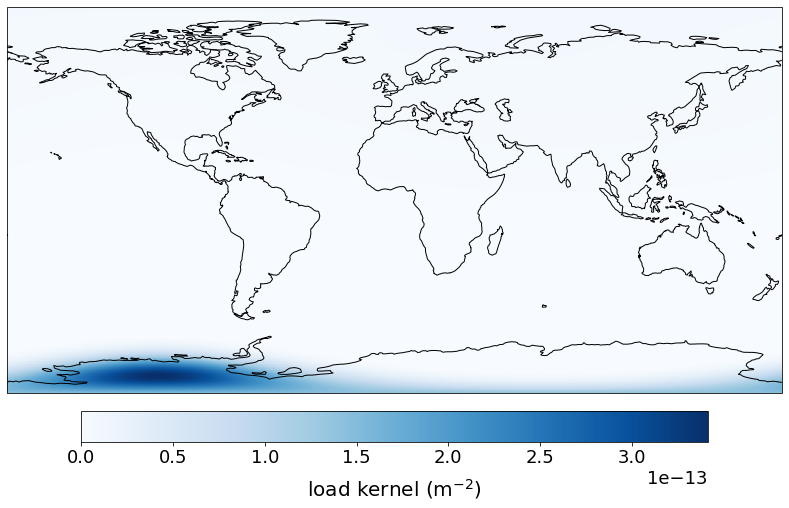

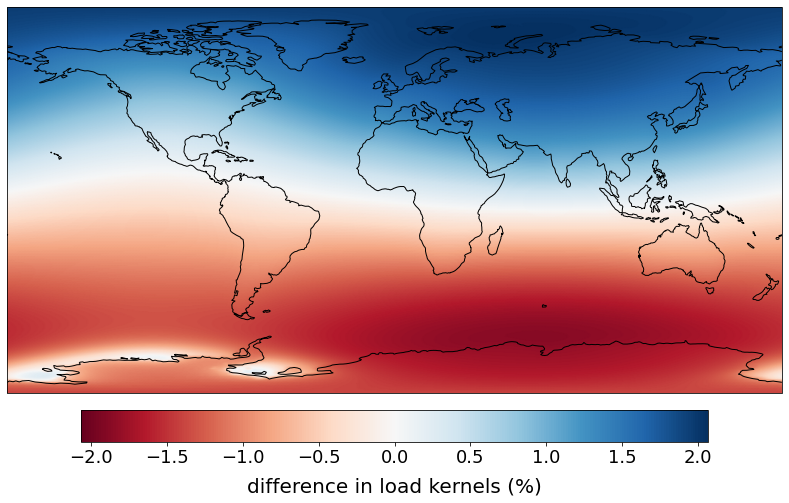

GRACE average of load =  -0.06366787649251511
average of direct load  =  -0.06908158216017363
relative difference with direct load average   =  -7.836684537864543 %


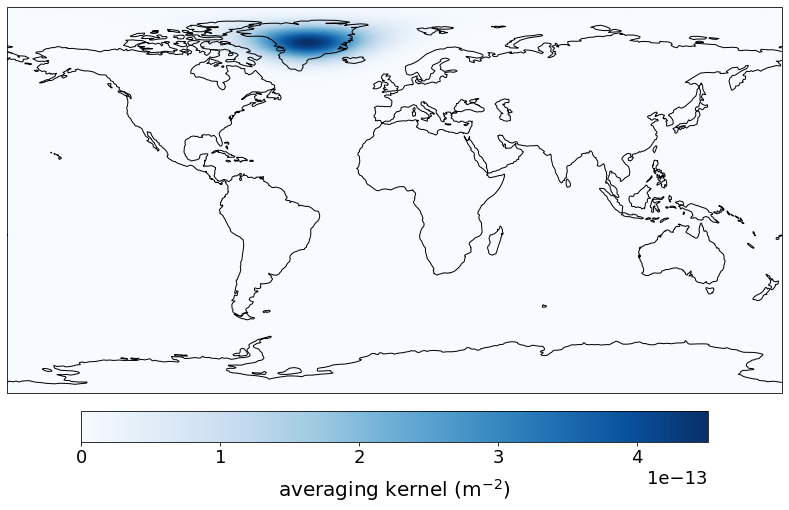

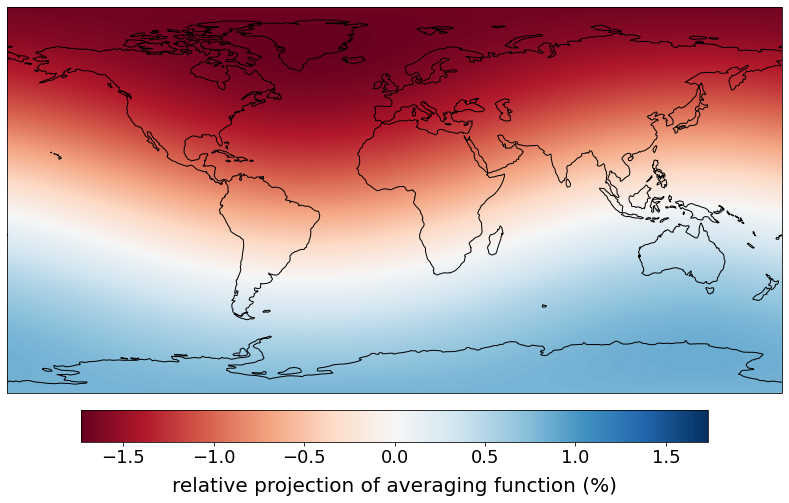

iteration =  1 relative change =  0.02122741350660077
iteration =  2 relative change =  0.0012407543234731564
iteration =  3 relative change =  0.0001507006370392548
iteration =  4 relative change =  3.5989250000442525e-05
iteration =  5 relative change =  8.941717235182815e-06
iteration =  6 relative change =  2.3218601982052763e-06
iteration =  7 relative change =  6.303395159690609e-07
iteration =  8 relative change =  1.7833286740860192e-07
iteration =  9 relative change =  5.2263306427855315e-08
iteration =  10 relative change =  1.5754835424781873e-08
iteration =  11 relative change =  4.852607602787545e-09

left hand side            =  -116.87665424209202
right hand side           =  -116.87665713705549
relative difference       =  2.4769390356632218e-08



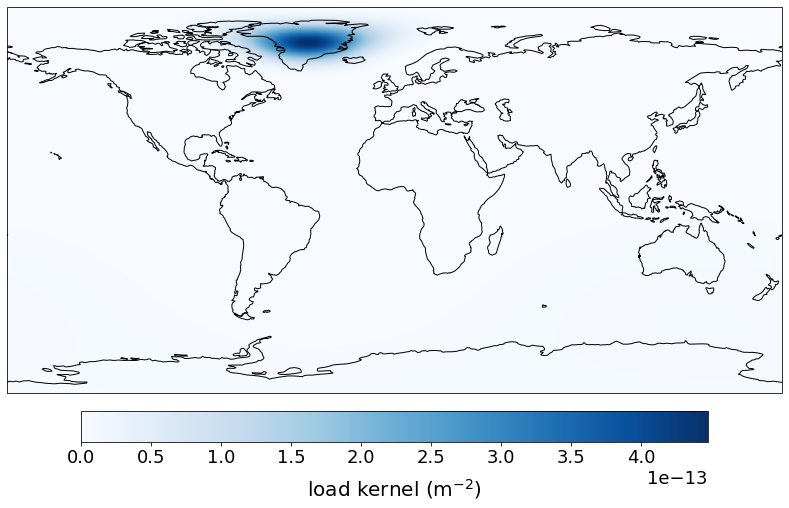

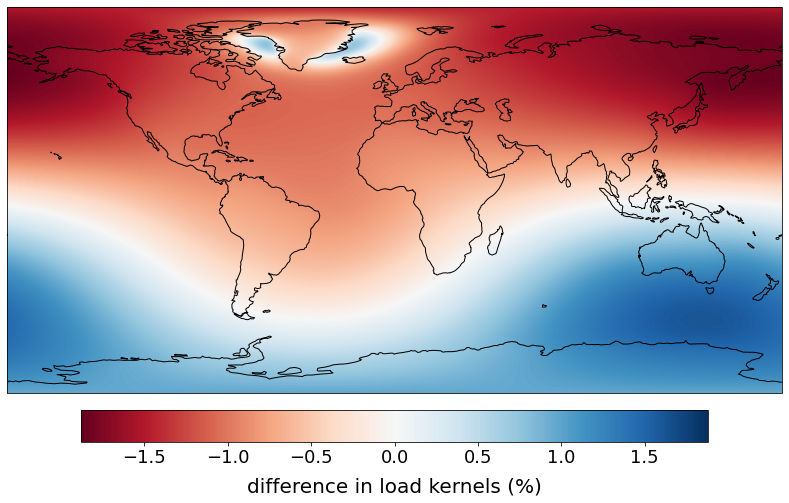

GRACE average of load =  -0.1168766571370555
average of direct load  =  -0.11122757419335506
relative difference with direct load average   =  5.078851161385773 %


In [63]:
# cut out degrees 0 and 1 from averaging function?
cut = False

# truncation degree for GRACE average (LT = 0 means no truncation)
LT = 100

# define the averaging function as in Wahr et al. (1998) targeted at W. Antarctic
w = SL.gaussian_averaging_function(L,r = 800,lat0 = -82.,lon0 = -110.,cut = cut)
SL.plot(w,label = r'averaging kernel (m$^{-2}$)',clim_pos = True)

wc = SL.gaussian_averaging_function(L,r = 800,lat0 = -82.,lon0 = -110.,cut = True)
norm = np.max(np.abs(w.data[:,:]))
SL.plot(100*(wc-w)/norm,label = r'relative projection of averaging function (%)')

# form the adjoint loads
zeta_d, zeta_u_d, zeta_phi_d, kk_d  = SL.GRACE_average_load(w,LT = LT)

# solve the adjoint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# check the kernel is working okay
lhs = SL.surface_integral(sl_d*zeta)
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g
print('')
print('left hand side            = ',lhs)
print('right hand side           = ',rhs)
print('relative difference       = ',np.abs((lhs-rhs)/lhs))
print('')

# plot the kernel wrt zeta
SL.plot(sl_d,label = r'load kernel (m$^{-2}$)',cmap = "Blues",clim_pos = True)

GRACE_average = SL.GRACE_average_measurement(phi,w,LT = LT)/SL.rhow
direct_load_average = SL.surface_integral(zeta*w)/SL.rhow

# plot the kernel wrt zeta
norm = np.max(np.abs(w.data[:,:]))
SL.plot(100*(sl_d-w)/norm,label = 'difference in load kernels (%)',clim_sym = True)

print('GRACE average of load = ',GRACE_average)
print('average of direct load  = ',direct_load_average)
print('relative difference with direct load average   = ',100*(GRACE_average-direct_load_average) \
                                                               /direct_load_average,'%')


##########################################################
# now do the same thing but for a Greenland average

# define the averaging function as in Wahr et al. (1998) targeted at Greenland
w = SL.gaussian_averaging_function(L,r = 700,lat0 = 73.,lon0 = -40.,cut = cut)
SL.plot(w,label = r'averaging kernel (m$^{-2}$)',clim_pos = True)

wc = SL.gaussian_averaging_function(L,r = 700,lat0 = 73.,lon0 = -40.,cut = True)
norm = np.max(np.abs(w.data[:,:]))
SL.plot(100*(wc-w)/norm,label = r'relative projection of averaging function (%)')

# form the adjoint loads
zeta_d, zeta_u_d, zeta_phi_d, kk_d  = SL.GRACE_average_load(w,LT = LT)

# solve the adjoint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# check the kernel is working okay
lhs = SL.surface_integral(sl_d*zeta)
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g
print('')
print('left hand side            = ',lhs)
print('right hand side           = ',rhs)
print('relative difference       = ',np.abs((lhs-rhs)/lhs))
print('')

# plot the kernel wrt zeta
SL.plot(sl_d,label = r'load kernel (m$^{-2}$)',clim_pos = True)

GRACE_average      = SL.GRACE_average_measurement(phi,w,LT = LT)/SL.rhow
direct_load_average = SL.surface_integral(zeta*w)/SL.rhow


# plot the kernel wrt zeta
norm = np.max(np.abs(w.data[:,:]))
SL.plot(100*(sl_d-w)/norm,label = 'difference in load kernels (%)')

print('GRACE average of load = ',GRACE_average)
print('average of direct load  = ',direct_load_average)
print('relative difference with direct load average   = ',100*(GRACE_average-direct_load_average) \
                                                               /direct_load_average,'%')



## Case 4: Sensitivity kernels for sea surface height

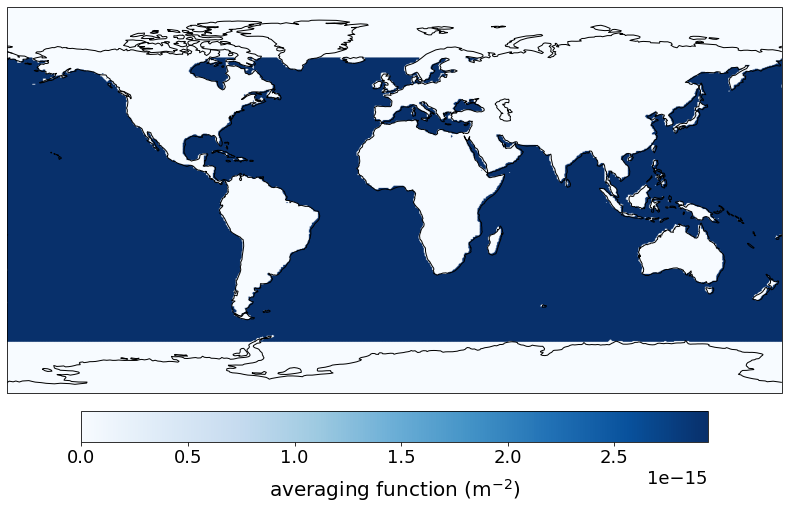

iteration =  1 relative change =  0.00943592265353918
iteration =  2 relative change =  0.0017996128889473187
iteration =  3 relative change =  0.0003988810565386072
iteration =  4 relative change =  8.918338810423801e-05
iteration =  5 relative change =  2.0143960369172435e-05
iteration =  6 relative change =  4.603404400400767e-06
iteration =  7 relative change =  1.0662497306792089e-06
iteration =  8 relative change =  2.5092348852708444e-07
iteration =  9 relative change =  6.018380565642177e-08
iteration =  10 relative change =  1.4766628539937287e-08
iteration =  11 relative change =  3.7209662669677035e-09

direct ssh value     =  0.004897083983080446
left hand side       =  0.004897083939827991
right hand side      =  0.00489708398308045
relative difference  =  8.832288828402218e-09



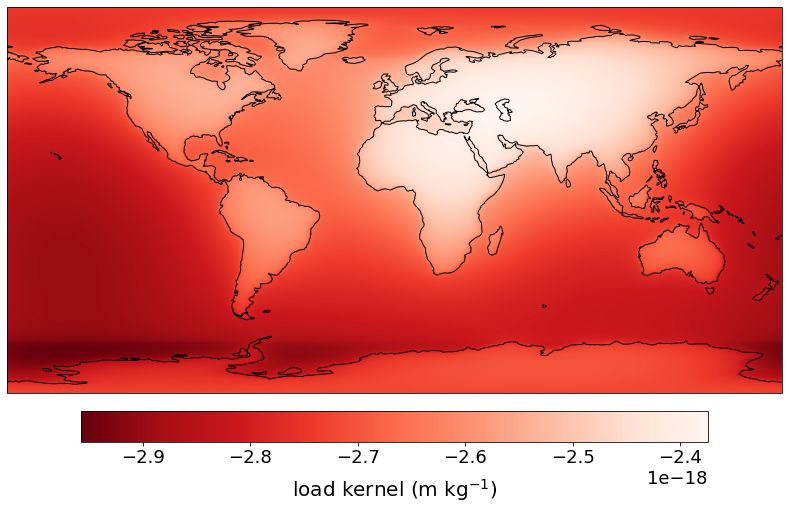

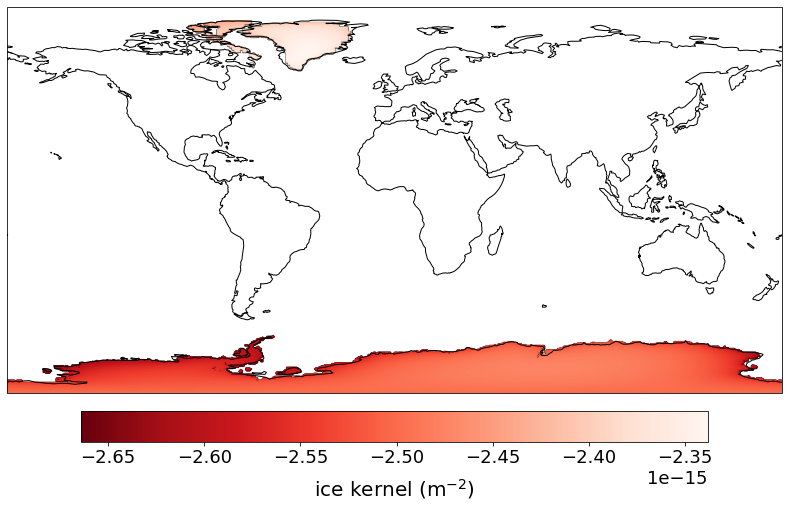

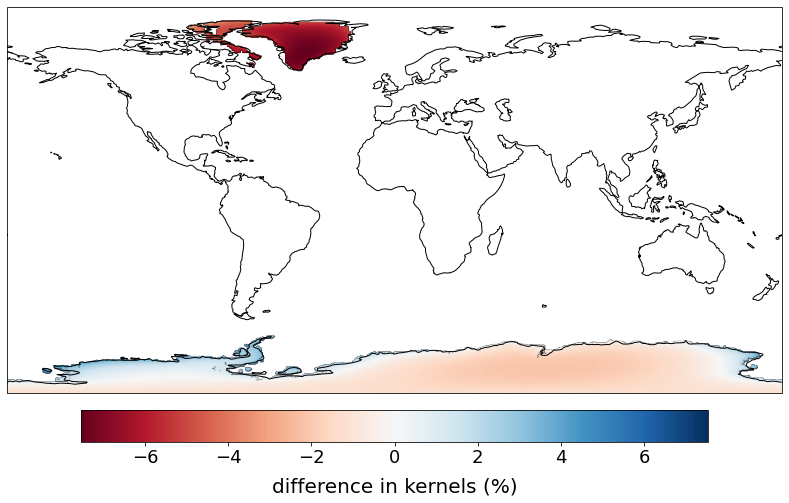

percentage difference from GMSL =  -2.0583203383910815 %

iteration =  1 relative change =  0.02060904185453243
iteration =  2 relative change =  0.0025169262083198163
iteration =  3 relative change =  0.00042134672355213494
iteration =  4 relative change =  8.325027392051262e-05
iteration =  5 relative change =  1.812564590701466e-05
iteration =  6 relative change =  4.256559386799434e-06
iteration =  7 relative change =  1.0727162493976702e-06
iteration =  8 relative change =  2.885491490074257e-07
iteration =  9 relative change =  8.248373877830528e-08
iteration =  10 relative change =  2.5226824017186605e-08
iteration =  11 relative change =  7.859452461975768e-09

percentage difference from GMSL =  -6.870949141967644 %


In [64]:


# set the adjoint loads
zeta_d, zeta_u_d, zeta_phi_d, kk_d  = SL.sea_altimetery_load(sl0,ice0)

SL.plot(zeta_d,label = r'averaging function (m$^{-2}$)',clim_pos = True)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# form the sea surface height directly
ssh = sl + u + psi/SL.g

# set the observational area and form the average
ssh_direct = SL.surface_integral(ssh*zeta_d)

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct ssh value     = ',ssh_direct)
print('left hand side       = ',lhs)
print('right hand side      = ',rhs)
print('relative difference  = ',np.abs((lhs-rhs)/lhs))
print('')


# plot the kernel wrt zeta
SL.plot(sl_d,label = r'load kernel (m kg$^{-1}$)',clim_sym = False,cmap = "Reds_r")

# plot the kernel wrt I
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,label = r'ice kernel (m$^{-2}$)',clim_sym = False,cmap = "Reds_r")

Kval = -SL.rhoi/(SL.rhow*A)
Ki = Kval*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(100*ice_mask*(K-Ki)/Kval,label = r'difference in kernels (%)')

# determine the difference between the altimetery estimate the GMSL
print('percentage difference from GMSL = ',100*(ssh_direct-GMSL)/np.abs(GMSL),"%")
print('')



#######################################################################
# do the same again, but now consider a northern hemisphere only source

zeta_2 = GMSL*zeta_north
sl_2,u_2,phi_2,om_2,psi_2 = SL.fingerprint(C,zeta_2)
ssh_2 = sl_2 + u_2 + psi_2/SL.g
ssh_direct = SL.surface_integral(ssh_2*zeta_d)
print('')
print('percentage difference from GMSL = ',100*(ssh_direct-GMSL)/np.abs(GMSL),"%")

